# Goals in this Notebook:
Make new files where the data is formatted similarly and limited to the same amount of time.

### Imports:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import time
import numpy as np
import random

%matplotlib inline

### Read in the Files:

In [ ]:
k2c1 = pd.read_csv('../clean_planet_data/clean_k2c1_done')

In [ ]:
c_planets = pd.read_csv('../clean_planet_data/extracted_planets_1_again.csv')

In [ ]:
c_planets_2 = pd.read_csv('../clean_planet_data/extracted_confirmed_planets_2_again.csv')

In [ ]:
kepc3 = pd.read_csv('../clean_planet_data/kepler_exo_train.csv')

In [2]:
c4_kep = pd.read_csv('../clean_planet_data/extracted_kep_c4_7700_backup.csv')

### Start Munging:

In [ ]:
cols = kepc3.columns
cols = cols.insert(0,'star_name')
cols

In [ ]:
kepc3['star_name'] = 'N/A'
kepc3 = kepc3[cols]

In [ ]:
kepc3['LABEL'] = kepc3['LABEL'] - 1
kepc3.head()

### Slice out the First 66 days of Observations:
That way there are no nulls and we can compare all the light curves from all datasets

In [ ]:
# max row length should be the number of columns in the kepc3 df
kepc3.shape

In [ ]:
# slice that number out of the other dfs
# clean_cut_planets = c_planets.iloc[:,:3199]
# clean_cut_k2c1 = k2c1.iloc[:,:3199]

### Check for Nulls:

In [ ]:
c_planets_2.isnull().sum().sum()

In [ ]:
clean_cut_k2c1.isnull().sum().sum()

In [ ]:
kepc3.isnull().sum().sum()

In [4]:
c4_kep.isnull().sum().sum()

2229590

In [5]:
c4_kep.head()

,star_name,exposure,c_flux_0,c_flux_1,c_flux_2,c_flux_3,c_flux_4,c_flux_5,c_flux_6,c_flux_7,...,c_flux_4387,c_flux_4388,c_flux_4389,c_flux_4390,c_flux_4391,c_flux_4392,c_flux_4393,c_flux_4394,c_flux_4395,c_flux_4396
0,KIC 1025494,82.716241,NaN,2.633382e+05,NaN,2.633493e+05,2.632883e+05,2.634034e+05,2.633153e+05,2.633076e+05,...,2.633262e+05,2.633096e+05,2.633450e+05,2.633055e+05,2.633076e+05,2.633412e+05,2.633336e+05,2.633332e+05,2.633176e+05,2.633526e+05
1,KIC 1025578,82.716237,NaN,1.292338e+04,NaN,1.291726e+04,1.291329e+04,1.292188e+04,1.292211e+04,1.291157e+04,...,1.291279e+04,1.291749e+04,1.292433e+04,1.292121e+04,1.291119e+04,1.291699e+04,1.291756e+04,1.293214e+04,1.293186e+04,1.290860e+04
2,KIC 1025986,82.716227,NaN,1.276864e+06,NaN,1.277233e+06,1.277410e+06,1.277653e+06,1.277849e+06,1.278068e+06,...,1.272619e+06,1.273011e+06,1.273417e+06,1.273826e+06,1.274113e+06,1.274493e+06,1.274748e+06,1.275238e+06,1.275759e+06,1.276052e+06
3,KIC 1026032,82.716228,NaN,1.743618e+04,NaN,1.742921e+04,1.743379e+04,1.743004e+04,1.743159e+04,1.742726e+04,...,1.739245e+04,1.739575e+04,1.739241e+04,1.740589e+04,1.739701e+04,1.738893e+04,1.740034e+04,1.739358e+04,1.738954e+04,1.738559e+04
4,KIC 1026133,82.716226,NaN,8.089427e+04,NaN,8.090219e+04,8.091389e+04,8.088692e+04,8.089593e+04,8.087595e+04,...,8.090645e+04,8.092413e+04,8.089960e+04,8.091161e+04,8.090157e+04,8.090039e+04,8.092984e+04,8.091438e+04,8.091408e+04,8.090827e+04


### Check for Duplicate Entries of Each Star:
If the value is greater than 1, there are duplicates.

The kepc3 dataframe shouldn't have duplicates, so no need to check.

In [ ]:
clean_cut_planets['star_name'].value_counts().max()

In [ ]:
clean_cut_k2c1['star_name'].value_counts().max()

Get rid of the duplicates in the clean_cut_planets dataframe.

In [ ]:
least_null_planets = pd.DataFrame(columns = c_planets.columns)

# selecting the row with the fewest NANs and add them to the least_null df
for df in [c_planets, c_planets_2]:
    for star in df['star_name'].unique():
        checking = df[df['star_name'] == star]
        best = checking[checking.count(axis = 1) == checking.count(axis = 1).max()]
        least_null_planets = pd.concat([least_null_planets, best])
    
least_null_planets.tail()

In [ ]:
least_null_planets.reset_index(drop=True, inplace = True)
least_null_planets.head()

In [ ]:
least_null_planets.shape

### Making a file that randomly selects different lightcurves from the data:

In [ ]:
randomized_planets = pd.DataFrame(columns = c_planets.columns)

i = 0

# selecting the row with the fewest NANs and add them to the least_null df
for df in [c_planets, c_planets_2]:
    for star in df['star_name'].unique():
        i += 1
        if i % 100 == 0:
            print(i)

        checking = df[df['star_name'] == star]
        rand_select = random.randint(checking.index.min(), checking.index.max() + 1)
#         print(checking.index.max())
        rand = checking[checking.index == rand_select]
        randomized_planets = pd.concat([randomized_planets, rand])
    

In [ ]:
randomized_planets.head()

In [ ]:
randomized_planets.reset_index(drop = True, inplace = True)

### Make sure it worked:

Is there only one row per star?

In [ ]:
least_null_planets['star_name'].value_counts().max()

How many nulls are there?

In [ ]:
least_null_planets.isnull().sum(axis=0) #.value_counts()

### Dealing with Nulls:

In [ ]:
has_planets = pd.read_csv('../clean_planet_data/least_null_planets_1_and_2.csv')
has_planets.head()

In [ ]:
# checking out which rows have the most nulls
counting = has_planets.isnull().sum(axis = 1)
counting.sort_values(ascending = False)

In [ ]:
has_planets = randomized_planets

In [7]:
# trying to fill one off missing values with mean imputation of the nearest two values

is_null = c4_kep.isnull()

for i in range(c4_kep.shape[0]):
    if i % 50 == 0:
        print(i)
    for j in range(c4_kep.shape[1]-1):
        if is_null.iloc[i, j] == True:
            if j > 2: # skip the first two columns
                if not ((is_null.iloc[i, j-1] == True) | (is_null.iloc[i, j+1] == True)):
                    c4_kep.iloc[i, j] = np.mean([c4_kep.iloc[i, j-1], c4_kep.iloc[i, j+1]])

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950
3000
3050
3100
3150
3200
3250
3300
3350
3400
3450
3500
3550
3600
3650
3700
3750
3800
3850
3900
3950
4000
4050
4100
4150
4200
4250
4300
4350
4400
4450
4500
4550
4600
4650
4700
4750
4800
4850
4900
4950
5000
5050
5100
5150
5200
5250
5300
5350
5400
5450
5500
5550
5600
5650
5700
5750
5800
5850
5900
5950
6000
6050
6100
6150
6200
6250
6300
6350
6400
6450
6500
6550
6600
6650
6700
6750
6800
6850
6900
6950
7000
7050
7100
7150
7200
7250
7300
7350
7400
7450
7500
7550
7600
7650
7700


IndexError: single positional indexer is out-of-bounds

In [8]:
c4_kep.tail()

,star_name,exposure,c_flux_0,c_flux_1,c_flux_2,c_flux_3,c_flux_4,c_flux_5,c_flux_6,c_flux_7,...,c_flux_4387,c_flux_4388,c_flux_4389,c_flux_4390,c_flux_4391,c_flux_4392,c_flux_4393,c_flux_4394,c_flux_4395,c_flux_4396
7709,KIC 10350885,82.715337,NaN,7623.983398,7621.442383,7618.901367,7619.235352,7622.194824,7621.204590,7620.562500,...,7630.180176,7622.295410,7622.823730,7617.355957,7619.765137,7622.042969,7624.842285,7618.821289,7622.912109,7616.748047
7710,KIC 10350897,82.715336,NaN,26916.777344,26915.885742,26914.994141,26919.958984,26918.572266,26908.222656,26908.228516,...,26919.679688,26921.416016,26923.566406,26912.509766,26910.720703,26913.734375,26913.478516,26905.394531,26912.882812,26919.970703
7711,KIC 10350908,82.715334,NaN,34512.160156,34508.902344,34505.644531,34503.800781,34504.421875,34504.312500,34496.136719,...,34487.054688,34478.097656,34488.691406,34487.871094,34477.843750,34473.847656,34481.492188,34475.078125,34503.753906,34487.878906
7712,KIC 10350930,82.715335,NaN,36407.671875,36406.587891,36405.503906,36404.976562,36405.671875,36413.835938,36398.070312,...,36403.890625,36405.367188,36394.554688,36396.453125,36395.523438,36416.394531,36402.796875,36404.425781,36409.992188,36403.644531
7713,KIC 10350934,82.715335,NaN,193577.687500,193601.148438,193624.609375,193678.750000,193672.109375,193637.609375,193635.828125,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
counting2 = has_planets[0:3200].isnull().sum(axis = 1)
counting2[0:3200].sort_values(ascending = False)[0:50]

In [ ]:
# count numbers of consecuative nans

is_null = has_planets.isnull()

for i in range(has_planets.shape[0]):
    counter = 0
    for j in range(has_planets.shape[1]):
        if j > 2:
            if is_null.iloc[i, j] == True:
                if is_null.iloc[i, j-1] == True:
                    counter +=1
                    print(counter)
                else:
                    counter = 0
#     print(counter)

In [ ]:
has_planets.shape

In [ ]:
# Shifting values to fill nulls
#     the column names will no longer be relevent
is_null = c4_kep.isnull()
df_squished = pd.DataFrame()

for i in range(c4_kep.shape[0]):
    if i % 50 == 0:
        print(i)
    
    k = 0 # reset the df_squished column index to 0 for each new row
    for j in range(c4_kep.shape[1]):
        if is_null.iloc[i, j] == False: # if this cell is not null
            df_squished.loc[i, k] = c4_kep.iloc[i, j]
            k += 1
#     if i > 5:
#         break
df_squished.tail()

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100


In [ ]:
df_squished.isnull().sum(axis = 1)

### Save to a New File:

In [ ]:
df_squished.to_csv('../clean_planet_data/clean_kep_c4.csv', index=False)

In [ ]:
# least_null_planets.to_csv('../clean_planet_data/least_null_planets_1_and_2.csv', index=False)

In [ ]:
# clean_cut_k2c1.to_csv('../clean_planet_data/clean_cut_k2c1.csv', index=False)

In [ ]:
# kepc3.to_csv('../clean_planet_data/clean_cut_kepc3.csv', index=False)

### Done!

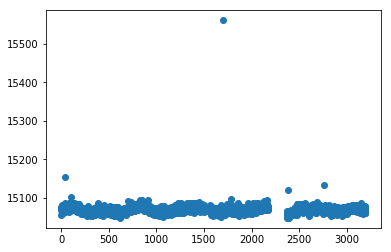

In [6]:
plt.scatter(list(range(len(c4_kep.iloc[1000,3:3199]))), list(c4_kep.iloc[1000,3:3199]))
# plt.ylim(19060, 19120)